# clothing Image Classification Using Transfer Learning


 Step 0: Import required libraries 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os
import prettytensor as pt

Step1: download the data for clothing images and labels from  
"https://stacks.stanford.edu/file/druid:tb980qz1002/ClothingAttributeDataset.zip"
and unzip the data. 

Step 2: Load & modify & clean data-labels

In [2]:
import re
import scipy.io

os.getcwd()

labels_dir='.\\ClothingAttributeDataset\\labels\\category_GT.mat'
cls = scipy.io.loadmat(labels_dir)
cls=cls['GT']
cls=cls-1
mask = ~np.any(np.isnan(cls), axis=1)
cls=cls[mask,:]

class_names = ['shirt','sweater','t-shirt','outerwear','suit','tank top','dress']
num_classes=len(class_names)
labels=np.full((cls.shape[0], len(class_names)),0)

for i in range (0,labels.shape[0]):
    labels[i,int(cls[i])]=1
cls=np.squeeze(cls)
    
print("Data length after removing Nan:\t\t{}".format(len(labels)))


Data length after removing Nan:		1104


Step 3: Load & modify & clean data-images

In [3]:
from PIL import Image
 
image_size=256
images_dir = '.\\ClothingAttributeDataset\\images/'
list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]

images=np.zeros((len(list_images),image_size,image_size,3))
for i in range (0,len(list_images)): 
    im = Image.open(list_images[i],'r')
    im_resized = im.resize((image_size,image_size),Image.ANTIALIAS)
    im_resized = np.array(im_resized, dtype=float)
    images[i,]=im_resized
    
images=images[mask,]

print("Resized image shapes:{}\t\t".format(im_resized.shape))


Resized image shapes:(256, 256, 3)		


Step 4: Divide data to test & train 

In [4]:
from sklearn import cross_validation
images_train, images_test, labels_train, labels_test = cross_validation.train_test_split(images, labels, test_size=0.2, random_state=42)
images_train, images_test, cls_train, cls_test = cross_validation.train_test_split(images, cls, test_size=0.2, random_state=42)

print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

C:\Users\hafez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Size of:
- Training-set:		883
- Test-set:		221


Step 5: Transfer pre-trained inception-V3 features to current data

In [11]:
# Transfer pre-trained inception-V3 features to current data
data_dir = "inception/"
path_graph_def = "classify_image_graph_def.pb"
tensor_name_transfer_layer="pool_3:0"
tensor_name_input_jpeg="DecodeJpeg/contents:0"
tensor_name_input_image = "DecodeJpeg:0"

path = os.path.join(data_dir, path_graph_def)
with tf.gfile.FastGFile(path, 'rb') as file:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(file.read())
    tf.import_graph_def(graph_def, name='')
    
def transfer(images):
    num_images = len(images)
    transfer_values = [None] * num_images
    with tf.Session() as se:
        transfer_layer = se.graph.get_tensor_by_name(tensor_name_transfer_layer)
        for i in range(num_images):
            feed_dict = {tensor_name_input_image: images[i]}
            TV = se.run(transfer_layer,feed_dict)
            transfer_values[i] = np.squeeze(TV)
            
    return transfer_values

transfer_values_train=transfer(images_train)
transfer_values_test=transfer(images_test)


Step 6: Before trainig NN , lets try something simple: SVM

In [12]:
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

clf = LinearSVC(C=0.1, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(transfer_values_train,cls_train)
cls_test_pred = clf.predict(transfer_values_test)

print("Accuracy: {0:0.1f}%".format(accuracy_score(cls_test,cls_test_pred)*100))

Accuracy: 69.2%


Step 7: Random batch and optimize functions for NN training

In [8]:
train_batch_size = 256
def random_batch():
    num_images = len(transfer_values_train)
    idx = np.random.choice(num_images,size=train_batch_size,replace=False)
   
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch


def optimize(num_iterations):
   
    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()
        feed_dict_train = {x: x_batch,y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy,feed_dict=feed_dict_train)
            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))



Step 8: Train NN on training data using Tensorflow

In [14]:
learning_rate=1e-4
num_iterations=10000

transfer_len = model.transfer_len
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=num_iterations)

Global Step:    100, Training Batch Accuracy:  91.8%
Global Step:    200, Training Batch Accuracy: 100.0%
Global Step:    300, Training Batch Accuracy: 100.0%
Global Step:    400, Training Batch Accuracy: 100.0%
Global Step:    500, Training Batch Accuracy:  99.6%
Global Step:    600, Training Batch Accuracy:  99.6%
Global Step:    700, Training Batch Accuracy:  99.6%
Global Step:    800, Training Batch Accuracy:  99.6%
Global Step:    900, Training Batch Accuracy:  99.2%
Global Step:   1000, Training Batch Accuracy: 100.0%
Global Step:   1100, Training Batch Accuracy: 100.0%
Global Step:   1200, Training Batch Accuracy: 100.0%
Global Step:   1300, Training Batch Accuracy: 100.0%
Global Step:   1400, Training Batch Accuracy: 100.0%
Global Step:   1500, Training Batch Accuracy: 100.0%
Global Step:   1600, Training Batch Accuracy:  99.6%
Global Step:   1700, Training Batch Accuracy: 100.0%
Global Step:   1800, Training Batch Accuracy:  99.6%
Global Step:   1900, Training Batch Accuracy: 

Step 9: Evaluate the results using confusion Matrix

Accuracy on Test-Set: 71.5% (158 / 221)


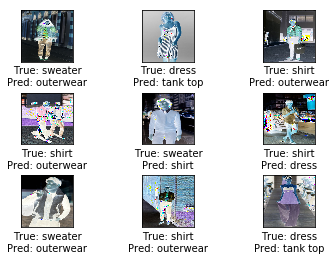

[10  0  1  6  0  1  3] (0) shirt
[4 6 0 4 0 0 1] (1) sweater
[ 0  0 24  0  0  1  0] (2) t-shirt
[ 6  3  0 44  6  0  3] (3) outerwear
[ 2  0  1  2 38  0  0] (4) suit
[3 0 1 0 0 7 1] (5) tank top
[ 0  1  1  6  0  6 29] (6) dress
 (0) (1) (2) (3) (4) (5) (6)


In [15]:
from sklearn.metrics import confusion_matrix
plot_number_incorrect=9

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    m=int(len(cls_pred)/3)
    fig, axes = plt.subplots(m,3)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
 
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            cls_true_name = class_names[int(cls_true[i])]
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
 
    
   
num_images = len(transfer_values_test)
cls_pred = np.zeros(shape=num_images, dtype=np.int)
feed_dict = {x: transfer_values_test,y_true: labels}
cls_pred= session.run(y_pred_cls, feed_dict=feed_dict)    
correct = (cls_test == cls_pred)
acc=correct.mean()
num_correct=correct.sum()
 
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, num_correct, num_images))

# Plot some examples of mis-classifications
incorrect = (correct == False)
images = images_test[incorrect]
cls_pred_in = cls_pred[incorrect]
cls_true = cls_test[incorrect]
n = min(plot_number_incorrect, len(images))
plot_images(images=images[0:n], cls_true=cls_true[0:n],cls_pred=cls_pred_in[0:n])
    

# Plot the confusion matrix
cm = confusion_matrix(y_true=cls_test,y_pred=cls_pred) 
# Append the class-name/number to line and columns.
for i in range(num_classes):
    class_name = "({}) {}".format(i, class_names[i])
    print(cm[i, :], class_name)
class_numbers = [" ({0})".format(i) for i in range(num_classes)]
print("".join(class_numbers)) 
        


In [11]:
#Close up if you are done
#session.close()